In [ ]:
!pip install tensorflow
!pip install tensorflow_hub
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import spacy

# Load the Spacy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])

In [ ]:
# Download GloVe vectors
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-04-23 13:59:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-23 13:59:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-23 14:00:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Load GloVe vectors
def load_glove_vectors(filename):
    embeddings = {}
    with open(filename, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_vectors('glove.6B.100d.txt')

In [ ]:
def get_glove_embedding(word):
    return glove_embeddings.get(word, np.zeros((100,)))

In [ ]:
elmo_layer = hub.KerasLayer("https://tfhub.dev/google/elmo/3", trainable=False, output_key='elmo', signature='tokens')

In [ ]:
def get_elmo_embedding(sentence, target_word=None):
    doc = nlp(sentence)
    tokens = [token.text for token in doc]

    if target_word is not None:
      idx = tokens.index(target_word)

    # Convert the tokens and sequence length to tensors
    tokens_tensor = tf.convert_to_tensor([tokens])
    sequence_len_tensor = tf.convert_to_tensor([len(tokens)])

    embeddings = elmo_layer(inputs={'tokens': tokens_tensor, 'sequence_len': sequence_len_tensor})

    if target_word is not None:
      return embeddings.numpy()[0][idx]
    else:
      return embeddings.numpy()

In [ ]:
word = "apple"
# Assuming you have the get_glove_embedding function already defined elsewhere
print("GloVe embedding for 'apple':", get_glove_embedding(word))
print("ELMo embedding for 'apple':", get_elmo_embedding("Apple is a fruit")[0][0])

GloVe embedding for 'apple': [-0.5985    -0.46321    0.13001   -0.019576   0.4603    -0.3018
  0.8977    -0.65634    0.66858   -0.49164    0.037557  -0.050889
  0.6451    -0.53882   -0.3765    -0.04312    0.51384    0.17783
  0.28596    0.92063   -0.49349   -0.48583    0.61321    0.78211
  0.19254    0.91228   -0.055596  -0.12512   -0.65688    0.068557
  0.55629    1.611     -0.0073642 -0.48879    0.45493    0.96105
 -0.063369   0.17432    0.9814    -1.3125    -0.15801   -0.54301
 -0.13888   -0.26146   -0.3691     0.26844   -0.24375   -0.19484
  0.62583   -0.7377     0.38351   -0.75004   -0.39053    0.091498
 -0.36591   -1.4715    -0.45228    0.2256     1.1412    -0.38526
 -0.06716    0.57288   -0.39191    0.31302   -0.29235   -0.96157
  0.15154   -0.21659    0.25103    0.096967   0.2843     1.4296
 -0.50565   -0.51374   -0.47218    0.32036    0.023149   0.22623
 -0.09725    0.82126    0.92599   -1.0086    -0.38639    0.86408
 -1.206     -0.28528    0.2265    -0.38773    0.40879    0.5

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


ELMo embedding for 'apple': [-0.7403609  -0.26720062  0.18574981 ... -0.11894065 -0.46448758
  0.15787096]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_contextual_embeddings(sentences, target_word):
    # Get GloVe embedding once as it doesn't use context
    glove_embedding = get_glove_embedding(target_word)
    elmo_embeddings = [get_elmo_embedding(sentence, target_word) for sentence in sentences]

    # Repeat the GloVe embedding to match the number of sentences
    glove_embeddings = [glove_embedding for _ in sentences]

    # Reduce dimensions using PCA for GloVe
    pca_glove = PCA(n_components=2)
    glove_2d = pca_glove.fit_transform(glove_embeddings)

    # Reduce dimensions using PCA for ELMo
    pca_elmo = PCA(n_components=2)
    elmo_2d = pca_elmo.fit_transform(elmo_embeddings)

    # Visualization
    plt.figure(figsize=(10, 5))

    for i, sentence in enumerate(sentences):
        plt.scatter(glove_2d[i, 0], glove_2d[i, 1], color='blue', label='GloVe' if i == 0 else "")
        plt.text(glove_2d[i, 0], glove_2d[i, 1], sentence, fontsize=9, color='blue')

        plt.scatter(elmo_2d[i, 0], elmo_2d[i, 1], color='red', label='ELMo' if i == 0 else "")
        plt.text(elmo_2d[i, 0], elmo_2d[i, 1], sentence, fontsize=9, color='red')

    plt.legend()
    plt.title(f"2D PCA of GloVe and ELMo embeddings for the word '{target_word}'")
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


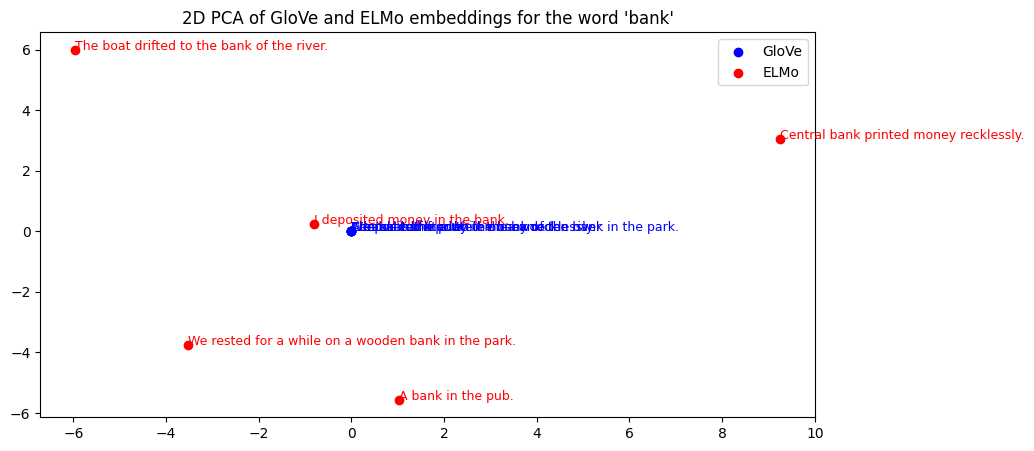

In [ ]:
contextual_sentences = [
    "I deposited money in the bank.",
    "The boat drifted to the bank of the river.",
    "We rested for a while on a wooden bank in the park.",
    "Central bank printed money recklessly.",
    "A bank in the pub.",
]

visualize_contextual_embeddings(contextual_sentences, "bank")

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.datasets import imdb

In [ ]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

17464789/17464789 [==============================] - 2s 0us/step


In [ ]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [ ]:
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

X_train_text = [decode_review(text) for text in X_train]
X_test_text = [decode_review(text) for text in X_test]

1641221/1641221 [==============================] - 1s 1us/step


In [ ]:
print(X_train_text[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sho

In [ ]:
def tokenize_sentences(texts):
    return [text.split() for text in texts]

X_train_tokenized = tokenize_sentences(X_train_text)
X_test_tokenized = tokenize_sentences(X_test_text)

In [ ]:
print(X_train_tokenized[0])

['<START>', 'this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you', 'could', 'just', 'imagine', 'being', 'there', 'robert', "redford's", 'is', 'an', 'amazing', 'actor', 'and', 'now', 'the', 'same', 'being', 'director', "norman's", 'father', 'came', 'from', 'the', 'same', 'scottish', 'island', 'as', 'myself', 'so', 'i', 'loved', 'the', 'fact', 'there', 'was', 'a', 'real', 'connection', 'with', 'this', 'film', 'the', 'witty', 'remarks', 'throughout', 'the', 'film', 'were', 'great', 'it', 'was', 'just', 'brilliant', 'so', 'much', 'that', 'i', 'bought', 'the', 'film', 'as', 'soon', 'as', 'it', 'was', 'released', 'for', 'retail', 'and', 'would', 'recommend', 'it', 'to', 'everyone', 'to', 'watch', 'and', 'the', 'fly', 'fishing', 'was', 'amazing', 'really', 'cried', 'at', 'the', 'end', 'it', 'was', 'so', 'sad', 'and', 'you', 'know', 'what', 'they', 'say', 'if', 'you', '

In [ ]:
elmo_layer = hub.KerasLayer("https://tfhub.dev/google/elmo/3", trainable=False, signature='tokens') #What happens with the trainable flag

In [ ]:
input_sample = tf.constant([["hello", "world"]])
output_sample = elmo_layer(inputs={
    'tokens': input_sample,
    'sequence_len': tf.constant([2])
})
print(output_sample)

tf.Tensor(
[[ 0.6059773  -0.41642076  0.12462263 ... -0.3262857   0.64256966
   0.10000686]], shape=(1, 1024), dtype=float32)


In [ ]:
import tensorflow as tf
from keras import layers, Model

class ElmoEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, elmo_model, **kwargs):
        self.elmo_model = elmo_model
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # No additional weights to train
        self.trainable = False
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x):
        sequence_lengths = tf.reduce_sum(tf.cast(tf.math.not_equal(x, ""), tf.int32), axis=1)
        embeddings = self.elmo_model(inputs={'tokens': x, 'sequence_len': sequence_lengths})
        return embeddings

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1024)


def build_model():
    input_text = tf.keras.layers.Input(shape=(None,), dtype=tf.string)
    embedding = ElmoEmbeddingLayer(elmo_model=elmo_layer)(input_text)
    #dense = tf.keras.layers.Dense(256, activation='relu')(embedding)
    dense = embedding
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()



In [ ]:
class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{5} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

model.fit(X_train_tokenized, y_train, epochs=5, batch_size=8, validation_split=0.2, callbacks=[PrintProgress()])

In [ ]:
loss, accuracy = model.evaluate(X_test_tokenized, y_test, verbose=1)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Highway(nn.Module):
    def __init__(self, size):
        super(Highway, self).__init__()
        self.linear1 = nn.Linear(size, size)
        self.linear2 = nn.Linear(size, size)

    def forward(self, x):
        gate = torch.sigmoid(self.linear1(x))
        nonlinear = F.relu(self.linear2(x))
        return gate * nonlinear + (1 - gate) * x

class CharCNN(nn.Module):
    def __init__(self, vocab_size, char_dim, num_filters, filter_sizes, max_token_length):
        super(CharCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, char_dim)
        self.convolutions = nn.ModuleList([
            nn.Conv2d(1, num_filters, (filter_size, char_dim))
            for filter_size in filter_sizes
        ])
        self.max_token_length = max_token_length
        self.projection_dim = 512
        self.highway = Highway(num_filters * len(filter_sizes))
        self.projection = nn.Linear(num_filters * len(filter_sizes), self.projection_dim)

    def forward(self, x):
        batch_size, num_tokens, _ = x.size()
        x = x.view(-1, self.max_token_length)  # Flatten to process each token
        x = self.embedding(x)  # Embed characters

        x = x.unsqueeze(1)  # Add channel dimension
        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.convolutions]
        pooled_results = [F.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in conv_results]
        concatenated = torch.cat(pooled_results, dim=1)

        concatenated = concatenated.view(batch_size, num_tokens, -1)  # Reshape to token level
        highway_output = self.highway(concatenated)
        projected_output = self.projection(highway_output)
        return projected_output



class ELMo(nn.Module):
    def __init__(self, char_vocab_size, char_dim=16, num_filters=32, filter_sizes=[1, 2, 3, 4, 5, 6, 7], lstm_hidden_dim=512):
        super(ELMo, self).__init__()

        self.char_cnn = CharCNN(char_vocab_size, char_dim, num_filters, filter_sizes)

        self.lstm1 = nn.LSTM(num_filters * len(filter_sizes), lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(2 * lstm_hidden_dim, lstm_hidden_dim, batch_first=True, bidirectional=True)

        self.layer_weights = nn.Parameter(torch.randn(3, requires_grad=True))
        self.gamma = nn.Parameter(torch.ones(1, requires_grad=True))

    def forward(self, x):
        representations = []

        char_repr = self.char_cnn(x)
        representations.append(char_repr)

        lstm1_out, _ = self.lstm1(char_repr)
        representations.append(lstm1_out)

        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = lstm1_out + lstm2_out
        representations.append(lstm2_out)

        layer_weights = torch.nn.functional.softmax(self.layer_weights, dim=0)
        elmo_representation = self.gamma * sum([weight * repr for weight, repr in zip(layer_weights, representations)])

        return elmo_representation


